## Figure 1C
## Figure S5B, S5D

In [1]:
import mat73
import h5py
import hdf5storage as st
# from pymatreader import read_mat
import pickle
import os

import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap
import matplotlib.patches as patches

from scipy.stats import wilcoxon, norm, kruskal, tukey_hsd, mannwhitneyu, sem
from scipy.optimize import curve_fit, minimize
from scipy.io import loadmat
from scipy.linalg import null_space
from scipy.spatial.distance import cdist

import seaborn as sns
from copy import deepcopy as dc
from statsmodels.stats.multitest import multipletests
import math
from itertools import combinations, product

from sklearn import svm
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, KFold, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA

from umap import UMAP

# from libsvm import svmutil

# import torch
# import torch.nn as nn
# import torch.optim as optim

# from pycaret.classification import *

c:\Users\USER\anaconda3\envs\final_test2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# loading variables

# openscope
with open('SVM_prerequisite_variables.pickle', 'rb') as f:
    SVM_prerequisite_variables = pickle.load(f)
    
    list_rate_w1 = SVM_prerequisite_variables['list_rate_w1'].copy()
    list_stm_w1 = SVM_prerequisite_variables['list_stm_w1'].copy()
    list_neu_loc = SVM_prerequisite_variables['list_neu_loc'].copy()
    list_wfdur = SVM_prerequisite_variables['list_wfdur'].copy()
    list_slopes_an_loglog = SVM_prerequisite_variables['list_slopes_an_loglog'].copy()
    list_slopes_an_loglog_12 = SVM_prerequisite_variables['list_slopes_an_loglog_12'].copy()

# ABO Neuropixels
with open('resp_matrix_ep_RS_all_32sess_allensdk.pickle', 'rb') as f:
    resp_matrix_ep_RS_all = pickle.load(f)

    list_rate_RS = resp_matrix_ep_RS_all['list_rate_RS'].copy()
    list_rate_RS_dr = resp_matrix_ep_RS_all['list_rate_RS_dr'].copy()
    list_rate_all = resp_matrix_ep_RS_all['list_rate_all'].copy()
    list_rate_all_dr = resp_matrix_ep_RS_all['list_rate_all_dr'].copy()
    list_slopes_RS_an_loglog = resp_matrix_ep_RS_all['list_slopes_RS_an_loglog'].copy()
    list_slopes_all_an_loglog = resp_matrix_ep_RS_all['list_slopes_all_an_loglog'].copy()

    sess_inds_qual_all = resp_matrix_ep_RS_all['sess_inds_qual_all'].copy()

In [3]:
def compute_mean_var_trial(label_cnt_dict, rate_sorted):    
    list_trial_mean = [[0]] * len(label_cnt_dict)
    list_trial_var = [[0]] * len(label_cnt_dict)

    for trial_ind, trial_type in enumerate(label_cnt_dict):
        
        trial_rate = np.array(rate_sorted.loc[:, trial_type])                
        trial_mean = np.mean(trial_rate, axis=1)
        trial_var = np.var(trial_rate, axis=1, ddof=1)

        trial_mean = pd.DataFrame(trial_mean, columns=[trial_type], index=rate_sorted.index)
        trial_var = pd.DataFrame(trial_var, columns=[trial_type], index=rate_sorted.index)
        list_trial_mean[trial_ind] = pd.concat([trial_mean] * label_cnt_dict[trial_type], axis=1)
        list_trial_var[trial_ind] = pd.concat([trial_var] * label_cnt_dict[trial_type], axis=1)

    rate_sorted_mean = pd.concat(list_trial_mean, axis=1)
    rate_sorted_var = pd.concat(list_trial_var, axis=1)

    return rate_sorted_mean, rate_sorted_var

In [4]:
def compute_mean_var_trial_collapse(label_cnt_dict, rate_sorted):    
    list_trial_mean = [[0]] * len(label_cnt_dict)
    list_trial_var = [[0]] * len(label_cnt_dict)

    for trial_ind, trial_type in enumerate(label_cnt_dict):
        
        trial_rate = np.array(rate_sorted.loc[:, trial_type])                
        trial_mean = np.mean(trial_rate, axis=1, dtype=np.longdouble)
        trial_var = np.var(trial_rate, axis=1, ddof=1, dtype=np.longdouble)

        trial_mean = pd.DataFrame(trial_mean, columns=[trial_type], index=rate_sorted.index)
        trial_var = pd.DataFrame(trial_var, columns=[trial_type], index=rate_sorted.index)
        list_trial_mean[trial_ind] = trial_mean.copy()
        list_trial_var[trial_ind] = trial_var.copy()

    rate_sorted_mean = pd.concat(list_trial_mean, axis=1)
    rate_sorted_var = pd.concat(list_trial_var, axis=1)

    return rate_sorted_mean, rate_sorted_var

In [5]:
# Function to compute cosine similarity
def cos_sim(x, y):
    # x and y are 1D vectors

    # dot_xy = np.dot(x, y)
    # norm_x, norm_y = np.linalg.norm(x), np.linalg.norm(y)

    # cos_sim = dot_xy / (norm_x * norm_y)

    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [6]:
def annotate_lineplot_significance(significant_values, axes, ax_ind, line_height_ratio, color):

    if len(significant_values) > 0:

        # Initialize start and end points of lines
        start = None
        lines = []
        dots = []

        # Loop through sorted significant_values to group them into lines or dots
        for i in range(len(significant_values) - 1):
            if start is None:
                start = significant_values[i]

            # Check if the next value is part of the same line
            if significant_values[i + 1] - significant_values[i] > 0.1 + 1e-9:  # Threshold for a gap; add pseudo-value to avoid floating point issue
                if start == significant_values[i]:
                    dots.append(start)  # Isolated point
                else:
                    lines.append((start, significant_values[i]))  # Line segment
                start = None

        # Check the last value
        if start is None:
            dots.append(significant_values[-1])
        else:
            lines.append((start, significant_values[-1]))

        # Plot lines and dots
        for line in lines:
            if isinstance(axes, np.ndarray):
                axes[ax_ind].hlines(axes[ax_ind].get_ylim()[0]+(axes[ax_ind].get_ylim()[1]-axes[ax_ind].get_ylim()[0])*line_height_ratio, \
                    xmin=line[0], xmax=line[1], colors=color)  # Draw a line
            elif isinstance(axes, plt.Axes):
                axes.hlines(axes.get_ylim()[0]+(axes.get_ylim()[1]-axes.get_ylim()[0])*line_height_ratio, \
                    xmin=line[0], xmax=line[1], colors=color)
            else:
                plt.hlines(plt.gca().get_ylim()[0]+(plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*line_height_ratio, \
                    xmin=line[0], xmax=line[1], colors=color)
                
        for dot in dots:
            if isinstance(axes, np.ndarray):
                axes[ax_ind].hlines(axes[ax_ind].get_ylim()[0]+(axes[ax_ind].get_ylim()[1]-axes[ax_ind].get_ylim()[0])*line_height_ratio, \
                    xmin=dot-0.01, xmax=dot+0.01, colors=color)  # Draw a very short line
            elif isinstance(axes, plt.Axes):
                axes.hlines(axes.get_ylim()[0]+(axes.get_ylim()[1]-axes.get_ylim()[0])*line_height_ratio, \
                    xmin=dot-0.01, xmax=dot+0.01, colors=color)
            else:
                plt.hlines(plt.gca().get_ylim()[0]+(plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*line_height_ratio, \
                    xmin=dot-0.01, xmax=dot+0.01, colors=color)

## Figure 1C bottom

wcfg1 Ic, Lc, Tre isomap (RRneuron)

session index: 6


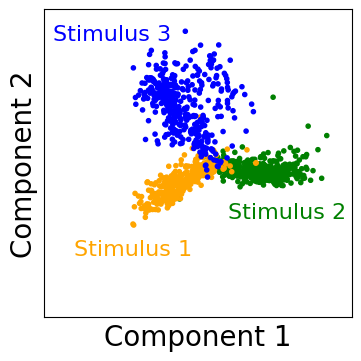

target_slope = 0.0


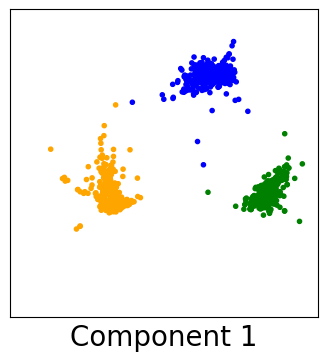

target_slope = 1.0


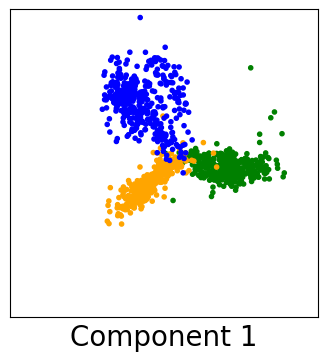

target_slope = 2.0


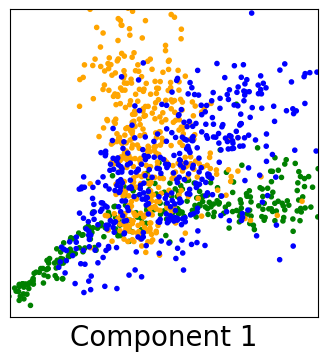

In [7]:
# wcfg1 Ic, Lc, Tre isomap (RRneuron) 
    
print(f'wcfg1 Ic, Lc, Tre isomap (RRneuron)\n')

num_trial_types = 12
num_trials = 400 
list_target_slopes = [0, 1, 2]

# Iterate over all sessions

for sess_ind, (rate_all, stm, neu_loc, wfdur) in enumerate(zip(list_rate_w1, list_stm_w1, list_neu_loc, list_wfdur)):
    
    if sess_ind == 6:
    
        print(f'session index: {sess_ind}')

        # rate_all transposition
        rate_all = rate_all.T.copy()

        # Extract V1 neurons
        ser_neu_loc = pd.Series(neu_loc)
        list_visp = [ser_neu_loc.str.contains('VISp'), ~ser_neu_loc.str.contains('VISpm')]
        rate = rate_all[[all(bools) for bools in zip(*list_visp)]].copy()
        # print(rate.shape[0])
        # list_visp_rs = [ser_neu_loc.str.contains('VISp'), ~ser_neu_loc.str.contains('VISpm'), (wfdur >= 0.4)]
        # rate = rate_all[[all(bools) for bools in zip(*list_visp_rs)]].copy()
        # print(np.sum([all(bools) for bools in zip(*list_visp_rs)]))

        # Multiply by delta t to convert to spike counts
        rate = rate * 0.4
        
        # Create a counting dictionary for each stimulus
        all_stm_unique, all_stm_counts = np.unique(stm, return_counts=True) 
        stm_cnt_dict = dict(zip(all_stm_unique, all_stm_counts))
        dict_trial_type = {0: 'Blank', 1: 'X', 2:'Tc1', 3: 'Ic1', 4: 'Lc1', 5:'Tc2', 6: 'Lc2', 7: 'Ic2', \
            8: 'Ire1', 9: 'Ire2', 10: 'Tre1', 11: 'Tre2', 12: 'Xre1', 13: 'Xre2', 14: 'BR_in', 15: 'BL_in', \
                16: 'TL_in', 17: 'TR_in', 18: 'BR_out', 19: 'BL_out', 20: 'TL_out', 21: 'TR_out'}
        
        # Create label array for all stimuli
        label = []
        for i in stm:
            for trial_type_num in dict_trial_type:
                if i == trial_type_num:
                    label.append(dict_trial_type[trial_type_num])
        label = np.array(label)

        # convert to dataframe
        rate = pd.DataFrame(rate, columns=label)

        # sort trials based on stimuli
        rate_sorted = rate.sort_index(axis=1)
        label_sorted = np.array(sorted(label))

        # Create a counting dictionary for each stimulus 
        all_label_unique, all_label_counts = np.unique(label, return_counts=True) 
        label_cnt_dict = dict(zip(all_label_unique, all_label_counts))

        # Extract stimuli having 400 repeats (trials)
        rate_sorted = rate_sorted.loc[:, all_label_unique[all_label_counts == 400]].copy()
        all_label_unique, all_label_counts = np.unique(rate_sorted.columns, return_counts=True) 
        label_cnt_dict = dict(zip(all_label_unique, all_label_counts))

        # Compute mean & variance for each stimulus
        rate_sorted_mean, rate_sorted_var = compute_mean_var_trial(label_cnt_dict, rate_sorted)
        rate_sorted_mean_coll, rate_sorted_var_coll = compute_mean_var_trial_collapse(label_cnt_dict, rate_sorted)

        list_slopes_dr = pd.DataFrame(list_slopes_an_loglog_12[sess_ind], \
                                    columns=rate_sorted_mean_coll.columns).copy()

        # isomap
        n_components = 2 # target number of dimensions
        # n_components = rate_sorted.shape[0] # target number of dimensions
        n_neighbors = 5 # number of neighbors

        isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
        
        rate_isomap = pd.DataFrame(isomap.fit_transform(rate_sorted.T).T, columns=rate_sorted.columns)
        rate_1_isomap = rate_isomap.loc[:, ['Ic1', 'Lc1', 'Tre1']].copy()
        rate_2_isomap = rate_isomap.loc[:, ['Ic2', 'Lc2', 'Tre2']].copy()
        rate_12_isomap = rate_isomap.loc[:, ['Ic1', 'Ic2', 'Lc1', 'Lc2', 'Tre1', 'Tre2']].copy()

        # # figure, axes
        # fig, axes = plt.subplots(2, len(list_target_slopes)+1, figsize=(16, 8)) 

        # color list & label list
        list_colors = ['green', 'orange', 'blue']
        list_colors_12 = ['greenyellow', 'forestgreen', 'sandybrown', 'orangered', 'dodgerblue', 'royalblue']
        list_colors_all = [list_colors, list_colors, list_colors_12, list_colors, list_colors, list_colors_12]

        list_labels_1 = ['Ic1', 'Lc1', 'Tre1']
        list_labels_2 = ['Ic2', 'Lc2', 'Tre2']
        list_labels_12 = ['Ic1', 'Ic2', 'Lc1', 'Lc2', 'Tre1', 'Tre2']
        list_labels_all = [list_labels_1, list_labels_2, list_labels_12, list_labels_1, list_labels_2, list_labels_12]
        
        # as-is scatterplot
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        ax.scatter(rate_1_isomap.iloc[0], rate_1_isomap.iloc[1], marker='.', \
                c=np.repeat(list_colors_all[0], num_trials))

        # ax.set_title('as-is', fontsize=20)
        ax.tick_params('both', labelsize=18)

        ax.set_xlim([-160, 160])
        ax.set_ylim([-160, 160])
        ax.set_aspect('equal')
        ax.set_xticks([]) # remove ticks and label
        ax.set_yticks([])
        ax.set_xlabel('Component 1', fontsize=20)
        ax.set_ylabel('Component 2', fontsize=20)

        ax.annotate(f'Stimulus 1', xy=(0.1, 0.2), xycoords='axes fraction', fontsize=16, color='orange')
        ax.annotate(f'Stimulus 2', xy=(0.6, 0.32), xycoords='axes fraction', fontsize=16, color='green')
        ax.annotate(f'Stimulus 3', xy=(0.03, 0.9), xycoords='axes fraction', fontsize=16, color='blue')

        plt.show()
        
        list_rate_RRneuron = np.empty(len(list_target_slopes), dtype=object)
        list_rate_RRneuron_isomap = np.zeros((len(list_target_slopes), 2, *rate_1_isomap.shape))
        for slope_ind, target_slope in enumerate(list_target_slopes):

            # Convert 0 to NaN (verified that cases of mean=0 and var=0 coincide exactly)
            rate_sorted_mean_coll[rate_sorted_mean_coll == 0] = np.nan
            rate_sorted_var_coll[rate_sorted_var_coll == 0] = np.nan
            
            print(f'target_slope = {target_slope:.1f}')

            # calculate target variance
            var_estim_dr = pd.DataFrame(np.zeros((1, rate_sorted_var_coll.shape[1])), \
                                    columns=rate_sorted_var_coll.columns) 
            for trial_type in rate_sorted_var_coll.columns:
                var_estim_dr.loc[:, trial_type] = \
                    np.nanmean(rate_sorted_var.loc[:, trial_type].values.flatten()) # nanmean
            # var_estim_dr = np.repeat(var_estim_dr, all_label_counts, axis=1) 
            # print(var_estim_dr)

            # offset = var_estim_dr.div(rate_sorted_var_coll.pow(target_slope/list_slopes_dr.iloc[0, :], axis=1).mean(axis=0))\
            # .mul(pow(10, target_slope * list_slopes_dr.iloc[1, :] / list_slopes_dr.iloc[0, :])) # collapsed 
            offset = pow(10, (list_slopes_dr.iloc[0, :]-target_slope) * np.log10(rate_sorted_mean_coll).mean(axis=0) + list_slopes_dr.iloc[1, :]) 

            var_rs_noisy = \
                pow(10, np.log10(rate_sorted_var_coll).sub(list_slopes_dr.iloc[1, :], axis=1)\
                    .div(list_slopes_dr.iloc[0, :], axis=1).mul(target_slope).add(np.log10(np.array(offset)), axis=1)) # collapsed
            var_rs_noisy = np.repeat(var_rs_noisy.values, all_label_counts, axis=1)

            # Compute changed residual and add back to the mean            
            rate_sorted_resid_dr = rate_sorted - rate_sorted_mean
            # rate_resid_RRneuron_dr = rate_sorted_resid_dr.div(np.sqrt(rate_sorted_var))\
            #     .mul(np.sqrt(rate_sorted_mean)).mul(np.sqrt(FF_estim_dr), axis=1)
            rate_resid_RRneuron_dr = rate_sorted_resid_dr.div(np.sqrt(rate_sorted_var))\
                .mul(np.sqrt(var_rs_noisy))
            # print(rate_resid_RRneuron_dr)
            rate_RRneuron_dr = rate_sorted_mean + rate_resid_RRneuron_dr
            rate_RRneuron_dr[rate_RRneuron_dr.isna()] = 0 # convert NaN to 0!        

            # Compute mean and variance of slope-changed data
            rate_mean_RRneuron_dr, rate_var_RRneuron_dr = \
                compute_mean_var_trial_collapse(label_cnt_dict, rate_RRneuron_dr)
            # FF_RRneuron = rate_var_RRneuron_dr.div(rate_mean_RRneuron_dr)
            # print(FF_RRneuron)
            # print(rate_var_RRneuron_dr)
            list_rate_RRneuron[slope_ind] = rate_RRneuron_dr.copy()
                        
            # Ic & Tre 추출 & z-scoring
            rate_1_RRneuron = rate_RRneuron_dr.loc[:, ['Ic1', 'Lc1', 'Tre1']].copy()
            rate_2_RRneuron = rate_RRneuron_dr.loc[:, ['Ic2', 'Lc2', 'Tre2']].copy()
            rate_12_RRneuron = rate_RRneuron_dr.loc[:, ['Ic1', 'Ic2', 'Lc1', 'Lc2', 'Tre1', 'Tre2']].copy()

            # isomap (RRneuron)
            rate_RRneuron_isomap = pd.DataFrame(isomap.fit_transform(rate_RRneuron_dr.T).T, columns=rate_RRneuron_dr.columns)
            rate_1_RRneuron_isomap = rate_RRneuron_isomap.loc[:, ['Ic1', 'Lc1', 'Tre1']].copy()
            rate_2_RRneuron_isomap = rate_RRneuron_isomap.loc[:, ['Ic2', 'Lc2', 'Tre2']].copy()
            rate_12_RRneuron_isomap = rate_RRneuron_isomap.loc[:, ['Ic1', 'Ic2', 'Lc1', 'Lc2', 'Tre1', 'Tre2']].copy()

            list_rate_RRneuron_isomap[slope_ind] = [rate_1_RRneuron_isomap, rate_2_RRneuron_isomap].copy()
            
            # 2D scatterplot
            fig, ax = plt.subplots(1, 1, figsize=(4, 4))
            ax.scatter(rate_1_RRneuron_isomap.iloc[0], rate_1_RRneuron_isomap.iloc[1], marker='.', \
                    c=np.repeat(list_colors_all[0], num_trials))

            # ax.set_title('as-is', fontsize=20)
            ax.tick_params('both', labelsize=18)
            
            ax.set_xlim([-160, 160])
            ax.set_ylim([-160, 160])
            ax.set_aspect('equal')
            ax.set_xticks([]) # remove ticks and label
            ax.set_yticks([])
            ax.set_xlabel('Component 1', fontsize=20)
            # ax.set_ylabel('Component 2', fontsize=20)

            plt.show()

## Figure S5B

sess_ind: 34
(85, 4500)


C:\Users\USER\AppData\Local\Temp\ipykernel_45204\872432694.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('turbo', len(stm_cnt_dict))
c:\Users\USER\anaconda3\envs\final_test2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\USER\anaconda3\envs\final_test2\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


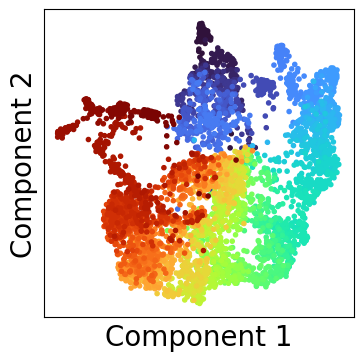

target_slope = 0.0


c:\Users\USER\anaconda3\envs\final_test2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\USER\anaconda3\envs\final_test2\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


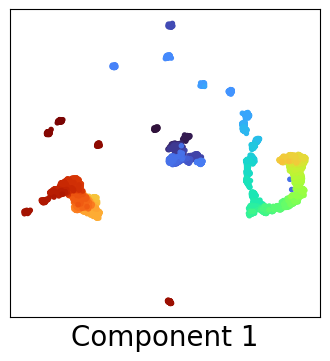

target_slope = 1.0


c:\Users\USER\anaconda3\envs\final_test2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\USER\anaconda3\envs\final_test2\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


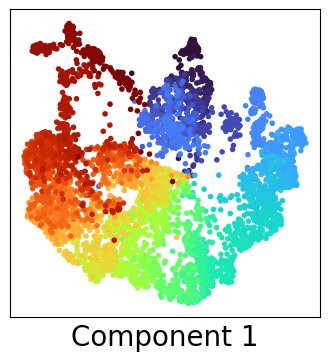

target_slope = 2.0


c:\Users\USER\anaconda3\envs\final_test2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\USER\anaconda3\envs\final_test2\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


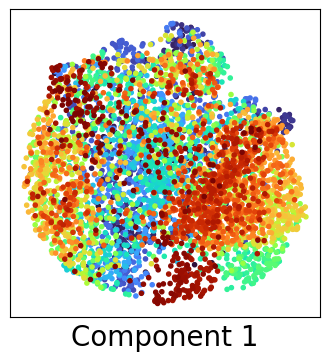

In [8]:
# Temporal trajectory plot (natural movie)

with open('resp_matrix_ep_naturalmovie_allensdk.pickle', 'rb') as f:
    resp_matrix_ep_naturalmovie_allensdk = pickle.load(f)

    list_rate_one_all = resp_matrix_ep_naturalmovie_allensdk['list_rate_one_all'].copy()    
    list_rate_three_all = resp_matrix_ep_naturalmovie_allensdk['list_rate_three_all'].copy()    
    list_slopes_nm_all_an_loglog2 = resp_matrix_ep_naturalmovie_allensdk['list_slopes_nm_all_an_loglog2'].copy()    
    list_slopes_flattened2 = resp_matrix_ep_naturalmovie_allensdk['list_slopes_flattened2'].copy()    
    list_sess_ids = resp_matrix_ep_naturalmovie_allensdk['list_sess_ids'].copy()    
    brain_observatory_sessid = resp_matrix_ep_naturalmovie_allensdk['brain_observatory_sessid'].copy()
    list_delta_t = resp_matrix_ep_naturalmovie_allensdk['list_delta_t'].copy()

list_target_slopes = [0, 1, 2]
# list_target_slopes = [0]

list_n_tt_frames = [1, 8, 12]
for frame_ind, n_tt_frame in enumerate(list_n_tt_frames):
    if frame_ind == 2:

        # Iterate over all sessions
        for sess_ind, sess_id in enumerate(list_sess_ids):
            # if ~np.any(np.isin(sess_ind, [4, 13, 42, 48, 49])): # 4, 13, 42: movie one truncation; 48, 49: no V1 neurons
            # if sess_ind in [14, 22, 34, 37]: # good example sessions
            if sess_ind == 34:

                print(f'sess_ind: {sess_ind}')
            
                rate_one = list_rate_one_all[sess_ind, frame_ind].copy()
                rate_one.columns = rate_one.columns + 0.1 # tag for movie one
                # print(rate_one.columns[:30])
                
                if np.isin(sess_id, brain_observatory_sessid):
                    rate_three = list_rate_three_all[sess_ind, frame_ind].sort_index(axis=1)
                    rate_three.columns = rate_three.columns + 0.3 # tag for movie three

                    rate = pd.concat([rate_one, rate_three], axis=1) # movie one & three concatenation
                    stm = rate.columns.copy()
                else:
                    rate = rate_one.copy()
                    stm = rate_one.columns.copy()
                
                rate_sorted = rate.sort_index(axis=1)
                stm = rate_sorted.columns.copy()

                # Multiply by delta t to convert to spike counts
                rate_sorted = round(rate_sorted * list_delta_t[frame_ind])
                print(rate_sorted.shape)

                # Create a counting dictionary for each stimulus
                all_stm_unique, all_stm_counts = np.unique(stm, return_counts=True) 
                stm_cnt_dict = dict(zip(all_stm_unique, all_stm_counts))
                
                # analyze only movie one
                bool_one = (all_stm_unique*10) % 10 == 1 
                all_stm_unique_one = all_stm_unique[bool_one].copy()
                
                rate_sorted = rate_sorted.loc[:, all_stm_unique_one].copy()
                stm = rate_sorted.columns.copy()
                all_stm_unique, all_stm_counts = np.unique(stm, return_counts=True) 
                stm_cnt_dict = dict(zip(all_stm_unique, all_stm_counts))

                # Compute mean & variance for each stimulus
                rate_sorted_mean, rate_sorted_var = compute_mean_var_trial(stm_cnt_dict, rate_sorted)
                rate_sorted_mean_coll, rate_sorted_var_coll = compute_mean_var_trial_collapse(stm_cnt_dict, rate_sorted)
                
                list_slopes_dr = pd.DataFrame(list_slopes_nm_all_an_loglog2[frame_ind][sess_ind][:, bool_one],
                                              columns=all_stm_unique_one).copy() # analyze only movie one!

                # temporal trajectory (colored along time)
                
                # color list
                cmap = get_cmap('turbo', len(stm_cnt_dict))
                _, stm_rep = np.unique(stm, return_inverse=True)

                # umap

                n_components = 2 # target number of dimensions
                n_neighbors = int(rate_sorted.shape[1] / 90) # number of neighbors
                min_dist = 0.4
                random_state = 5

                umap = UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
                rate_umap = umap.fit_transform(rate_sorted.T).T

                # 2D
                fig, ax = plt.subplots(figsize=(4, 4))
                sct = ax.scatter(rate_umap[0], rate_umap[1], marker='.', c=stm_rep, cmap=cmap)
                
                # cbar = fig.colorbar(sct)
                # cbar.set_label('Time', fontsize=20, rotation=270, labelpad=25)
                # cbar.set_ticks([])

                ax.set_xlabel('Component 1', fontsize=20)
                ax.set_ylabel('Component 2', fontsize=20)
                # ax.set_zlabel('Component 3', fontsize=20)
                # ax.set_aspect('equal')
                ax.set_xticks([]) # remove ticks and label
                ax.set_yticks([])
                ax.tick_params('both', labelsize=18)

                plt.show()

                # Convert 0 to NaN (verified that cases of mean=0 and var=0 coincide exactly)
                rate_sorted_mean_coll[rate_sorted_mean_coll == 0] = np.nan
                rate_sorted_var_coll[rate_sorted_var_coll == 0] = np.nan

                for slope_ind, target_slope in enumerate(list_target_slopes):
                    print(f'target_slope = {target_slope:.1f}')

                    # calculate target variance
                    var_estim_dr = pd.DataFrame(np.zeros((1, rate_sorted_var_coll.shape[1])), \
                                            columns=rate_sorted_var_coll.columns) 
                    for trial_type in rate_sorted_var_coll.columns:
                        var_estim_dr.loc[:, trial_type] = \
                            np.nanmean(rate_sorted_var.loc[:, trial_type].values.flatten()) # nanmean

                    # offset = var_estim_dr.div(rate_sorted_var_coll.pow(target_slope/list_slopes_dr.iloc[0, :], axis=1).mean(axis=0))\
                    # .mul(pow(10, target_slope * list_slopes_dr.iloc[1, :] / list_slopes_dr.iloc[0, :])) # collapsed 
                    offset = pow(10, (list_slopes_dr.iloc[0, :]-target_slope) * np.nanmean(np.log10(rate_sorted_mean_coll), axis=0) + list_slopes_dr.iloc[1, :]) 

                    var_rs_noisy = \
                        pow(10, np.log10(rate_sorted_var_coll).sub(list_slopes_dr.iloc[1, :], axis=1)\
                            .div(list_slopes_dr.iloc[0, :], axis=1).mul(target_slope).add(np.log10(np.array(offset)), axis=1)) # collapsed
                    var_rs_noisy = np.repeat(np.array(var_rs_noisy), all_stm_counts, axis=1) 

                    # Compute changed residual and add back to the mean            
                    rate_sorted_resid_dr = rate_sorted - rate_sorted_mean
                    rate_resid_RRneuron_dr = rate_sorted_resid_dr.div(np.sqrt(rate_sorted_var))\
                        .mul(np.sqrt(var_rs_noisy))
                    rate_RRneuron_dr = rate_sorted_mean + rate_resid_RRneuron_dr
                    rate_RRneuron_dr[rate_RRneuron_dr.isna()] = 0 # convert NaN to 0!    

                    # Compute mean and variance of slope-changed data
                    rate_mean_RRneuron_coll, rate_var_RRneuron_coll = \
                        compute_mean_var_trial_collapse(stm_cnt_dict, rate_RRneuron_dr)
                    
                    # temporal trajectory (colored along time)

                    # umap

                    n_components = 2 # target number of dimensions
                    n_neighbors = int(rate_RRneuron_dr.shape[1] / 90) # number of neighbors
                    min_dist = 0.4
                    random_state = 5

                    umap = UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
                    rate_RRneuron_umap = umap.fit_transform(rate_RRneuron_dr.T).T

                    # 2D
                    fig, ax = plt.subplots(figsize=(4, 4))
                    ax.scatter(rate_RRneuron_umap[0], rate_RRneuron_umap[1], marker='.', c=stm_rep, cmap=cmap, picker=True)

                    ax.set_xlabel('Component 1', fontsize=20)
                    # ax.set_ylabel('Component 2', fontsize=20)
                    # ax.set_zlabel('Component 3', fontsize=20)
                    # ax.set_aspect('equal')
                    ax.set_xticks([]) # remove ticks and label
                    ax.set_yticks([])
                    ax.tick_params('both', labelsize=18)

                    plt.show()

## Figure S5D

session index: 14


c:\Users\USER\anaconda3\envs\final_test2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\USER\anaconda3\envs\final_test2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[93, 8, 62]


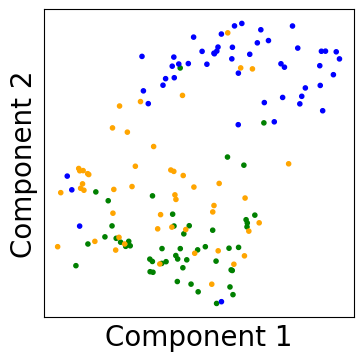

target_slope = 0.0


c:\Users\USER\anaconda3\envs\final_test2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\USER\anaconda3\envs\final_test2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


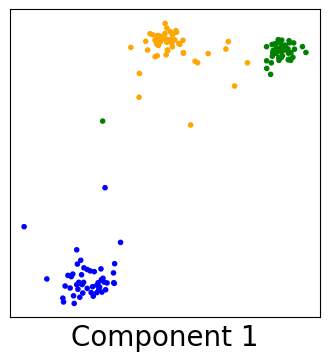

target_slope = 1.0


c:\Users\USER\anaconda3\envs\final_test2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\USER\anaconda3\envs\final_test2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


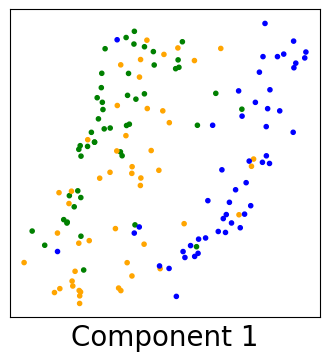

target_slope = 2.0


c:\Users\USER\anaconda3\envs\final_test2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\USER\anaconda3\envs\final_test2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


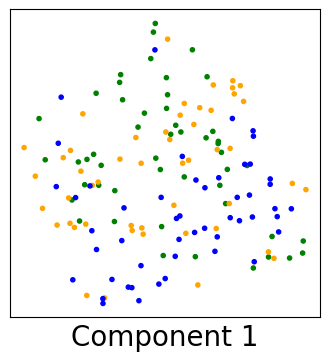

In [9]:
# natural scenes umap (RRneuron) (trial type trio)
    
list_target_slopes_short = [0, 1, 2]

num_sess = 32
num_trials = 50

# Iterate over all sessions

# list_dims = np.zeros((num_sess, len(list_target_slopes_short)+1))
for sess_ind, rate in enumerate(list_rate_all):
    if sess_ind == 14:
        print(f'session index: {sess_ind}')
        
        rate_sorted = rate.sort_index(axis=1)
        stm = rate_sorted.columns.copy()

        # Multiply by delta t to convert to spike counts
        rate_sorted = rate_sorted * 0.25

        # Create a counting dictionary for each stimulus
        all_stm_unique, all_stm_counts = np.unique(stm, return_counts=True) 
        stm_cnt_dict = dict(zip(all_stm_unique, all_stm_counts))

        # Compute mean & variance for each stimulus
        rate_sorted_mean, rate_sorted_var = compute_mean_var_trial(stm_cnt_dict, rate_sorted)
        rate_sorted_mean_coll, rate_sorted_var_coll = compute_mean_var_trial_collapse(stm_cnt_dict, rate_sorted)

        list_slopes_dr = pd.DataFrame(list_slopes_all_an_loglog[sess_ind], \
                                    columns=rate_sorted_mean_coll.columns).copy()

        # umap
        n_components = 2 # target number of dimensions
        n_neighbors = int(rate_sorted.shape[1] / 90) # number of neighbors
        min_dist = 0.4
        random_state = 5

        umap = UMAP(n_neighbors=n_neighbors, n_components=n_components, min_dist=min_dist)
        target = np.array(stm).copy()
        target[np.random.choice(rate_sorted.shape[1], size=int(0.5*rate_sorted.shape[1]), replace=False)] = -1
        
        rate_umap = pd.DataFrame(umap.fit_transform(rate_sorted.T, y=target).T, columns=rate_sorted.columns) 
        # rate_trio_umap = rate_umap.loc[:, adj_tt_trio].copy()
        # rand_tt_trio = np.random.choice(all_stm_unique, 3, replace=False)
        rand_tt_trio = [93, 8, 62]
        print(rand_tt_trio)
        rate_trio_umap = rate_umap.loc[:, rand_tt_trio].copy()

        # figure, axes
        # fig, axes = plt.subplots(1, len(list_target_slopes_short)+1, figsize=(12, 4)) 

        # color list & label list
        list_colors = ['green', 'orange', 'blue']
        
        # as-is scatterplot
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        ax.scatter(rate_trio_umap.iloc[0], rate_trio_umap.iloc[1], marker='.', \
                c=np.repeat(list_colors, num_trials))

        # ax.set_title('as-is', fontsize=20)
        ax.tick_params('both', labelsize=18)

        # ax.set_aspect('equal')
        ax.set_xticks([]) # remove ticks and label
        ax.set_yticks([])
        ax.set_xlabel('Component 1', fontsize=20)
        ax.set_ylabel('Component 2', fontsize=20)

        plt.show()

        # Convert 0 to NaN (verified that cases of mean=0 and var=0 coincide exactly)
        rate_sorted_mean_coll[rate_sorted_mean_coll == 0] = np.nan
        rate_sorted_var_coll[rate_sorted_var_coll == 0] = np.nan
        
        list_rate_RRneuron_umap = np.zeros((len(list_target_slopes_short), *rate_trio_umap.shape))
        for slope_ind, target_slope in enumerate(list_target_slopes_short):
            print(f'target_slope = {target_slope:.1f}')

            # calculate target variance
            var_estim_dr = pd.DataFrame(np.zeros((1, rate_sorted_var_coll.shape[1])), \
                                    columns=rate_sorted_var_coll.columns) 
            for trial_type in rate_sorted_var_coll.columns:
                var_estim_dr.loc[:, trial_type] = \
                    np.nanmean(rate_sorted_var.loc[:, trial_type].values.flatten()) # nanmean
            # var_estim_dr = np.repeat(var_estim_dr, all_stm_counts, axis=1) 
            # print(var_estim_dr)

            # offset = var_estim_dr.div(rate_sorted_var_coll.pow(target_slope/list_slopes_dr.iloc[0, :], axis=1).mean(axis=0))\
            # .mul(pow(10, target_slope * list_slopes_dr.iloc[1, :] / list_slopes_dr.iloc[0, :])) # collapsed 
            offset = pow(10, (list_slopes_dr.iloc[0, :]-target_slope) * np.log10(rate_sorted_mean_coll).mean(axis=0) + list_slopes_dr.iloc[1, :]) 

            var_rs_noisy = \
                pow(10, np.log10(rate_sorted_var_coll).sub(list_slopes_dr.iloc[1, :], axis=1)\
                    .div(list_slopes_dr.iloc[0, :], axis=1).mul(target_slope).add(np.log10(np.array(offset)), axis=1)) # collapsed
            var_rs_noisy = np.repeat(var_rs_noisy.values, all_stm_counts, axis=1)

            # Compute changed residual and add back to the mean            
            rate_sorted_resid_dr = rate_sorted - rate_sorted_mean
            # rate_resid_RRneuron_dr = rate_sorted_resid_dr.div(np.sqrt(rate_sorted_var))\
            #     .mul(np.sqrt(rate_sorted_mean)).mul(np.sqrt(FF_estim_dr), axis=1)
            rate_resid_RRneuron_dr = rate_sorted_resid_dr.div(np.sqrt(rate_sorted_var))\
                .mul(np.sqrt(var_rs_noisy))
            # print(rate_resid_RRneuron_dr)
            rate_RRneuron_dr = rate_sorted_mean + rate_resid_RRneuron_dr
            rate_RRneuron_dr[rate_RRneuron_dr.isna()] = 0 # convert NaN to 0!        

            # Compute mean and variance of slope-changed data
            rate_mean_RRneuron_dr, rate_var_RRneuron_dr = \
                compute_mean_var_trial_collapse(stm_cnt_dict, rate_RRneuron_dr)
            # FF_RRneuron = rate_var_RRneuron_dr.div(rate_mean_RRneuron_dr)
            # print(FF_RRneuron)
            # print(rate_var_RRneuron_dr)

            # umap
            rate_RRneuron_umap = pd.DataFrame(umap.fit_transform(rate_RRneuron_dr.T, y=target).T, columns=rate_RRneuron_dr.columns)
            # rate_trio_RRneuron_umap = rate_RRneuron_umap.loc[:, adj_tt_trio].copy()
            rate_trio_RRneuron_umap = rate_RRneuron_umap.loc[:, rand_tt_trio].copy()

            list_rate_RRneuron_umap[slope_ind] = rate_trio_RRneuron_umap.copy()
            
            # 2D scatterplot
            fig, ax = plt.subplots(1, 1, figsize=(4, 4))
            # ax.axhline(0, c='0.7') 
            # ax.axvline(0, c='0.7') 
            ax.scatter(rate_trio_RRneuron_umap.iloc[0], rate_trio_RRneuron_umap.iloc[1], marker='.', \
                    c=np.repeat(list_colors, num_trials))

            # ax.set_title(f'Slope {target_slope}', fontsize=20)
            ax.tick_params('both', labelsize=18)

            # ax.set_aspect('equal')
            ax.set_xticks([]) # remove ticks and label
            ax.set_yticks([])
            ax.set_xlabel('Component 1', fontsize=20)
            # ax.set_ylabel('Component 2', fontsize=20)

            plt.show()